In [1]:
import pandas as pd
import numpy as np

from scipy import stats
import matplotlib.pylab as plt
from tqdm.notebook import tqdm
from scipy.special import gamma

from joblib import Parallel, delayed

import datetime

In [2]:
input_data = pd.read_csv('STORAGE_data/es-1min_FULL.csv')
input_data.index = pd.to_datetime(input_data.date + ' ' + input_data.time)
input_data

,date,time,open,high,low,close
2011-12-19 09:30:00,12/19/2011,9:30:00,1215.875,1216.375,1215.625,1215.875
2011-12-19 09:31:00,12/19/2011,9:31:00,1215.875,1217.125,1215.875,1217.125
2011-12-19 09:32:00,12/19/2011,9:32:00,1217.125,1217.875,1217.125,1217.625
2011-12-19 09:33:00,12/19/2011,9:33:00,1217.625,1218.375,1217.625,1218.125
2011-12-19 09:34:00,12/19/2011,9:34:00,1218.125,1218.375,1217.625,1217.875
...,...,...,...,...,...,...
2015-12-16 16:10:00,12/16/2015,16:10:00,2070.125,2070.375,2069.875,2070.125
2015-12-16 16:11:00,12/16/2015,16:11:00,2070.125,2070.875,2069.125,2069.250
2015-12-16 16:12:00,12/16/2015,16:12:00,2069.250,2072.125,2069.125,2072.125
2015-12-16 16:13:00,12/16/2015,16:13:00,2072.125,2072.625,2071.625,2072.000


In [3]:
data = input_data.drop(['date', 'time'], axis=1)

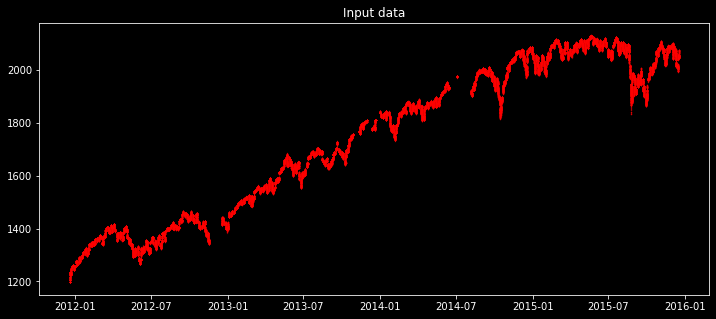

In [4]:
plt.style.use('dark_background')
plt.figure(figsize=(12,5))
plt.plot(data.close, 'o', markersize=.3, color='red', alpha=.6)
plt.title('Input data')
plt.show()

In [5]:
def _start_duplicates_removing(inp_data):
    #   Clean duplicates
    ret_data = inp_data.reset_index().drop_duplicates(subset='index', keep='first').set_index('index')
    #   Check success of cleaning
    assert len(ret_data.index) == len(ret_data.index.unique())
    print(f'Duplicates at {1 - (ret_data.shape[0] / inp_data.shape[0]):.2%} of data')
    return ret_data

def normalize_data(inp_data: pd.DataFrame, show=True):
    #   Calculate the right numbers of observations intra day
    NORMAL_MINUTES = (15 - 9) * 60 + 30
    #   Checks for duplicates
    if show:
        plt.style.use('dark_background')
        plt.figure(figsize=(12,8))
        plt.subplot(2,1,1)
        plt.plot(inp_data.close, 'o', markersize=.3, color='red', alpha=.6)
        plt.title('Input data')

    if len(inp_data.index) != len(inp_data.index.unique()):
        inp_data = _start_duplicates_removing(inp_data)
    #   In data not of all information about trade-day. For example at date 2011-12-19 data ends at 15:59. At date 2015-12-19 data ends at 16:14. Notice that normal trade day ends at 16:30.
    #   At start lets drop lines with days with zero observations.
    mask = ~np.in1d(inp_data.index.date,inp_data.resample('1D').count().query(f'open < {NORMAL_MINUTES}').index.date)

    if show:
        plt.subplot(2,1,2)
        plt.plot(inp_data.loc[mask,:].close, 'o', markersize=.3, color='red', alpha=.6)
        plt.title('Cut data')
        plt.show()
    #   Shows percent of "bad" dotes
    print(f"Bad days at {1 - (len(mask) / len(inp_data)):.2%} observations")
    return inp_data.loc[mask,:]

In [6]:
#nrm = normalize_data(data)

In [7]:
"""THRESHOLD = 0.014
#THRESHOLD = 0.0001

def order_logic(OP, CL, X):
    if (OP / CL) - 1 > X:
        return True, 'LONG'
    if (OP / CL) - 1 < -1 * X:
        return True, 'SHORT',
    else:
        return False, 'FALSE',

# def order_return(inp_data: pd.DataFrame, MONEY, OP, TYPE):
#     SLIPADGE = 10
#     CLOSE = inp_data.iloc[-1].close
#     if TYPE == 'SHORT':
#         return (2 * MONEY) - ((MONEY / OP) * CLOSE) - SLIPADGE
#     if TYPE == 'LONG':
#         return (MONEY / OP) * CLOSE - SLIPADGE

def order_return(inp_data: pd.DataFrame, MONEY, OP, TYPE, INDEX):
    loss_data = inp_data.loc[INDEX:]
    SLIPADGE = 20
    BATCH = 1
    LOSS_PERCENT = 0.05
    CLOSE = inp_data.iloc[-1].close

    if TYPE == 'SHORT':
        for _ in loss_data.index:
            if (loss_data.loc[_,:].open / OP) - 1 > LOSS_PERCENT:
                return BATCH * (OP - loss_data.loc[_,:].close) - SLIPADGE
        return BATCH * (OP - CLOSE) - SLIPADGE
    if TYPE == 'LONG':
        for _ in loss_data.index:
            if (loss_data.loc[_,:].open / OP) - 1 < -1 * LOSS_PERCENT:
                return BATCH * (loss_data.loc[_,:].close - OP) - SLIPADGE
        return BATCH * (CLOSE - OP) - SLIPADGE

MONEY = 10
MONEY_ARRAY = list()
DATES_ARRAY = list()


ALL_index_array = nrm.index
for index in tqdm(np.unique(nrm.index[:].date)):
    _true_index = pd.to_datetime(index) + datetime.timedelta(hours=14, minutes=30, seconds=0) # '2012-01-01' -> '2012-01-01 14:30:00'
    CURRENT = nrm.loc[_true_index,:].open
    back_index = _true_index - datetime.timedelta(days=1) + datetime.timedelta(minutes=30)
    forward_index = _true_index + datetime.timedelta(minutes=59)
    if (back_index in ALL_index_array) and (forward_index in ALL_index_array):
        DAY_BACK_CLOSE = nrm.loc[back_index,:].close
        DAY_CURRENT_CLOSE = nrm.loc[forward_index, :].close
        CURRENT_data = nrm.loc[index.strftime('%Y-%m-%d'): index.strftime('%Y-%m-%d')]
        if order_logic(CURRENT, DAY_BACK_CLOSE, THRESHOLD)[0]:
            TYPE = order_logic(CURRENT, DAY_BACK_CLOSE, THRESHOLD)[1]
            MONEY = MONEY + order_return(CURRENT_data, MONEY, CURRENT, TYPE, _true_index)
            if MONEY < 0:
                MONEY = 10
            MONEY_ARRAY.append(MONEY)
            DATES_ARRAY.append(index)

MONEY_ARRAY

def sharpe(MNY_RET):
    MNY_RET = np.array(MNY_RET)
    #LMNY = (np.diff(MNY_RET) / MNY_RET[:-1])
    LMNY = np.diff(np.log(MNY_RET))
    print(LMNY[:10])
    SHARPE = np.nanmean(LMNY)/ np.nanstd(LMNY)
    print('SHARPE:', SHARPE)
    return SHARPE

sharpe(MONEY_ARRAY)
"""

"THRESHOLD = 0.014\n#THRESHOLD = 0.0001\n\ndef order_logic(OP, CL, X):\n    if (OP / CL) - 1 > X:\n        return True, 'LONG'\n    if (OP / CL) - 1 < -1 * X:\n        return True, 'SHORT',\n    else:\n        return False, 'FALSE',\n\n# def order_return(inp_data: pd.DataFrame, MONEY, OP, TYPE):\n#     SLIPADGE = 10\n#     CLOSE = inp_data.iloc[-1].close\n#     if TYPE == 'SHORT':\n#         return (2 * MONEY) - ((MONEY / OP) * CLOSE) - SLIPADGE\n#     if TYPE == 'LONG':\n#         return (MONEY / OP) * CLOSE - SLIPADGE\n\ndef order_return(inp_data: pd.DataFrame, MONEY, OP, TYPE, INDEX):\n    loss_data = inp_data.loc[INDEX:]\n    SLIPADGE = 20\n    BATCH = 1\n    LOSS_PERCENT = 0.05\n    CLOSE = inp_data.iloc[-1].close\n\n    if TYPE == 'SHORT':\n        for _ in loss_data.index:\n            if (loss_data.loc[_,:].open / OP) - 1 > LOSS_PERCENT:\n                return BATCH * (OP - loss_data.loc[_,:].close) - SLIPADGE\n        return BATCH * (OP - CLOSE) - SLIPADGE\n    if TYPE == 'LO

In [25]:
def backtest(nrm: pd.DataFrame, THRESHOLD, LOSS_PERCENT, MINUTES_TO_CLOSE, LOOKBACK=1, TAKE_PROFIT=False):
    SHORT = 0
    LONG = 0
    STOP_LOSS = 0
    if TAKE_PROFIT:
        TAKE_PROF = 0

    THRESHOLD = THRESHOLD
    #THRESHOLD = 0.0001

    def order_logic(OP, CL, X):
        if (OP / CL) - 1 > X:
            return True, 'LONG'
        if (OP / CL) - 1 < -1 * X:
            return True, 'SHORT',
        else:
            return False, 'FALSE',



    def order_return(inp_data: pd.DataFrame, OP, TYPE, INDEX, LOSS_PERCENT, TAKE_PROFIT):
        loss_data = inp_data.loc[INDEX:]
        SLIPADGE = 20
        BATCH = 50
        LOSS_PERCENT = LOSS_PERCENT
        THR_TAKE_PROFIT = 0.004
        CLOSE = loss_data.iloc[-1].close
        #print(f"TYPE:{TYPE}| START:{OP}| CLOSE:{CLOSE}")
        if TYPE == 'SHORT':
            for _ in loss_data.index:
                if (loss_data.loc[_,:].open / OP) - 1 > LOSS_PERCENT:
                    return BATCH * (OP - loss_data.loc[_,:].close) - SLIPADGE, 'LOSS'

                if  TAKE_PROFIT:
                    if (OP / (loss_data.loc[_,:].open + SLIPADGE)) - 1 > THR_TAKE_PROFIT:
                        return BATCH * (OP - loss_data.loc[_,:].close) - SLIPADGE, 'TAKE'
            return BATCH * (OP - CLOSE) - SLIPADGE, 'NULL'
        if TYPE == 'LONG':
            for _ in loss_data.index:
                if (loss_data.loc[_,:].open / OP) - 1 < -1 * LOSS_PERCENT:
                    return BATCH * (loss_data.loc[_,:].close - OP) - SLIPADGE, 'LOSS'

                if  TAKE_PROFIT:
                    if (loss_data.loc[_,:].open / (OP + SLIPADGE)) - 1 > THR_TAKE_PROFIT:
                        return BATCH * (OP - loss_data.loc[_,:].close) - SLIPADGE, 'TAKE'
            return BATCH * (CLOSE - OP) - SLIPADGE, 'NULL'

    MONEY = 0
    MONEY_ARRAY = list()
    DATES_ARRAY = list()


    C0 = 0
    C1 = 0
    C2 = 0
    ALL_index_array = nrm.index
    ALL_index_dates_array = np.unique(nrm.index.date)
    for _ARROW_, index in enumerate(tqdm(np.unique(nrm.index[:].date)[LOOKBACK:])):
        C0 += 1
        #print(index)
        _true_index = nrm.loc[index.strftime('%Y-%m-%d')].iloc[-1].name - datetime.timedelta(minutes=MINUTES_TO_CLOSE)
        if (index - datetime.timedelta(days=LOOKBACK)) in ALL_index_dates_array:
            C1 += 1
            #   Здесь можно поменять lookback назад. Но нужно менять логику взятия последнего значения. Сейчас выбирается весь день удовлетворяющий АКТУАЛЬНЫЙ_ДЕНЬ - ТАЙМШИФТНАЗАД
            back_index = nrm.loc[(index - datetime.timedelta(days=LOOKBACK)).strftime('%Y-%m-%d')].iloc[-1].name
            forward_index = nrm.loc[index.strftime('%Y-%m-%d')].iloc[-1].name
            #print(_true_index)
            #print(nrm.loc[_true_index:index.strftime('%Y-%m-%d'),:])
            #print(nrm.loc[_true_index:index.strftime('%Y-%m-%d'),:].iloc[0])
            #CURRENT = nrm.loc[_true_index,:].open
            CURRENT = nrm.loc[_true_index:index.strftime('%Y-%m-%d'),:].iloc[0].open
            DAY_BACK_CLOSE = nrm.loc[back_index,:].close
            DAY_CURRENT_CLOSE = nrm.loc[forward_index, :].close
            #print(F"ARROW: {_ARROW_} TRUE: {_true_index}, back: {back_index} forward: {forward_index}")
            CURRENT_data = nrm.loc[index.strftime('%Y-%m-%d')]
            if order_logic(CURRENT, DAY_BACK_CLOSE, THRESHOLD)[0]:
                TYPE = order_logic(CURRENT, DAY_BACK_CLOSE, THRESHOLD)[1]
                if TYPE == 'SHORT':
                    SHORT += 1
                if TYPE == 'LONG':
                    LONG += 1

                RET = order_return(CURRENT_data, CURRENT, TYPE, _true_index, LOSS_PERCENT=LOSS_PERCENT, TAKE_PROFIT=TAKE_PROFIT)
                if RET[1] == 'LOSS':
                    STOP_LOSS += 1
                if TAKE_PROFIT:
                    if RET[1] == 'TAKE':
                        TAKE_PROF += 1
                MONEY = MONEY + RET[0]
                if MONEY < 0:
                    MONEY = 0
                MONEY_ARRAY.append(MONEY)
                DATES_ARRAY.append(index)


        if (index - datetime.timedelta(days=LOOKBACK)) not in ALL_index_dates_array:
            C2 += 1
            back_index = nrm.loc[:index - datetime.timedelta(days=LOOKBACK)].iloc[-1].name.date()
            forward_index = nrm.loc[index.strftime('%Y-%m-%d')].iloc[-1].name
            #print(_true_index)
            #print(nrm.loc[_true_index:index.strftime('%Y-%m-%d'),:])
            #print(nrm.loc[_true_index:index.strftime('%Y-%m-%d'),:].iloc[0])
            #CURRENT = nrm.loc[_true_index,:].open
            CURRENT = nrm.loc[_true_index:index.strftime('%Y-%m-%d'),:].iloc[0].open
            DAY_BACK_CLOSE = nrm.loc[back_index.strftime('%Y-%m-%d'),:].close[-1]
            DAY_CURRENT_CLOSE = nrm.loc[forward_index, :].close
            #print(F"ARROW: {_ARROW_} TRUE: {_true_index}, back: {back_index} forward: {forward_index}")
            CURRENT_data = nrm.loc[index.strftime('%Y-%m-%d')]
            if order_logic(CURRENT, DAY_BACK_CLOSE, THRESHOLD)[0]:
                TYPE = order_logic(CURRENT, DAY_BACK_CLOSE, THRESHOLD)[1]
                if TYPE == 'SHORT':
                    SHORT += 1
                if TYPE == 'LONG':
                    LONG += 1

                RET = order_return(CURRENT_data, CURRENT, TYPE, _true_index, LOSS_PERCENT=LOSS_PERCENT, TAKE_PROFIT=TAKE_PROFIT)
                if RET[1] == 'LOSS':
                    STOP_LOSS += 1

                if TAKE_PROFIT:
                    if RET[1] == 'TAKE':
                        TAKE_PROF += 1
                MONEY = MONEY + RET[0]
                if MONEY < 0:
                    MONEY = 0
                MONEY_ARRAY.append(MONEY)
                DATES_ARRAY.append(index)

    return_dict = [('HOLD', int(MINUTES_TO_CLOSE)),
         ('LOOKBACK', int(LOOKBACK)),
         ('THRESHOLD', THRESHOLD),
         ('STOP_LOSS_PERCENT', LOSS_PERCENT),
         ('LOOKBACK_THROUGH_WEEKENS', int(C2)),
         ('LOOKBACK_NORMAL', int(C1)),
         ('SUMMARY_TRADE_DAYS', int(C0)),
         ('TOTAL_TRADES', int(len(MONEY_ARRAY))),
         ('SHORT_TRADES', int(SHORT)),
         ('LONG_TRADES', int(LONG)),
         ('STOP_LOSS_TRADES', int(STOP_LOSS))]

    if TAKE_PROFIT:
        return_dict.append(('TAKE_PROFIT_TRADES', TAKE_PROF))

    DF = pd.DataFrame.from_dict(return_dict)
    """
    DF = DF.T
    DF.columns = DF.iloc[0].values
    DF = DF.drop([0])"""

    return DATES_ARRAY, MONEY_ARRAY, DF

def sharpe(MONEY_ARRAY, DATES_ARRAY, BEAUTIFUL_PNL=True):
    MONEY_DF = pd.DataFrame(columns=['date', 'pnl'])

    for e, _ in enumerate(pd.date_range(min(DATES_ARRAY), max(DATES_ARRAY))):
        if _.date() in DATES_ARRAY:
            MONEY_DF = MONEY_DF.append([{'date': _.date(), 'pnl': MONEY_ARRAY[DATES_ARRAY.index(_)]}])
        if _.date() not in DATES_ARRAY:
            MONEY_DF = MONEY_DF.append([{'date': _.date(), 'pnl': MONEY_DF.iloc[-1].pnl}])

    if BEAUTIFUL_PNL:
        plt.figure(figsize=(18, 10))
        plt.xticks(rotation=90)
        plt.grid(alpha=.1)
        plt.plot(MONEY_DF.set_index('date'))
        plt.show()

    MNY_RET = MONEY_DF.pnl.pct_change()[1:].replace([np.inf, -np.inf, np.nan], 0).values
    MNY_RET = np.subtract(np.array(MNY_RET), 0.05/252)
    SHARPE = np.mean(MNY_RET)/ np.std(MNY_RET)
    print('SHARPE:', round(np.sqrt(len(MNY_RET)) * SHARPE, 3))
    return round(np.sqrt(len(MNY_RET)) * SHARPE, 3)

In [9]:
ddd = normalize_data(data, show=False)

Duplicates at 6.18% of data
Bad days at 0.00% observations


  0%|          | 0/902 [00:00<?, ?it/s]

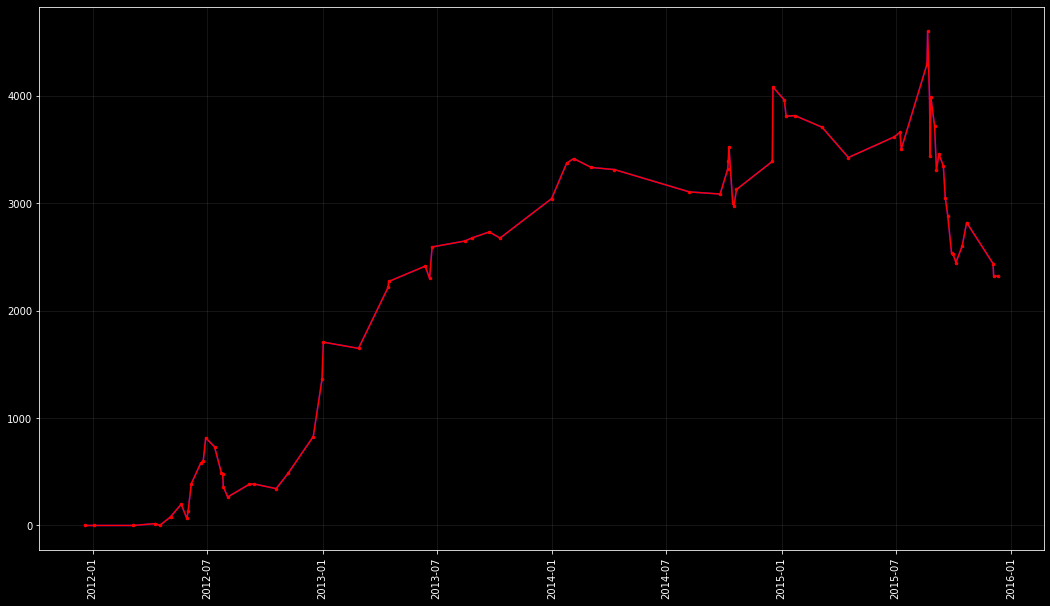

In [27]:

#DATES_ARRAY, MONEY_ARRAY, INFO = backtest(nrm=ddd,THRESHOLD=0.012, LOSS_PERCENT=0.004, MINUTES_TO_CLOSE=120, LOOKBACK=1, TAKE_PROFIT=False)
DATES_ARRAY, MONEY_ARRAY, INFO = backtest(nrm=ddd,THRESHOLD=0.014, LOSS_PERCENT=0.004, MINUTES_TO_CLOSE=45, LOOKBACK=1, TAKE_PROFIT=False)
plt.figure(figsize=(18, 10))
plt.xticks(rotation=90)
plt.grid(alpha=0.1)
plt.plot(DATES_ARRAY, MONEY_ARRAY, linestyle='-', color='blue')
plt.plot(DATES_ARRAY, MONEY_ARRAY, marker='o', markersize=2.5, color='red')
plt.show()

In [28]:
INFO

,0,1
0,HOLD,45.000
1,LOOKBACK,1.000
2,THRESHOLD,0.014
3,STOP_LOSS_PERCENT,0.004
4,LOOKBACK_THROUGH_WEEKENS,209.000
5,LOOKBACK_NORMAL,693.000
6,SUMMARY_TRADE_DAYS,902.000
7,TOTAL_TRADES,77.000
8,SHORT_TRADES,39.000
9,LONG_TRADES,38.000


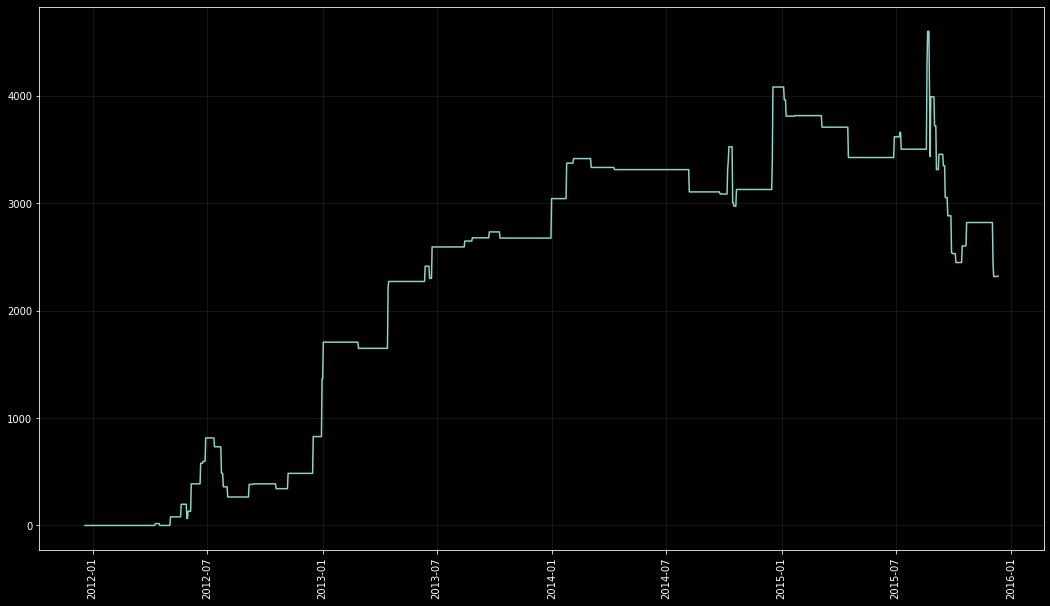

SHARPE: 1.607


1.607

In [29]:
sharpe(MONEY_ARRAY, DATES_ARRAY)

In [ ]:
DATES_ARRAY, MONEY_ARRAY = backtest(nrm=ddd,THRESHOLD=0.012, LOSS_PERCENT=0.004, MINUTES_TO_CLOSE=45)
plt.figure(figsize=(8, 4))
plt.xticks(rotation=90)
plt.plot(DATES_ARRAY, MONEY_ARRAY, linestyle='-', color='blue')
plt.plot(DATES_ARRAY, MONEY_ARRAY, marker='o', markersize=2.5, color='red')
plt.show()

In [ ]:
DATES_ARRAY, MONEY_ARRAY = backtest(nrm=data.drop_duplicates(),THRESHOLD=0.012, LOSS_PERCENT=0.004,  MINUTES_TO_CLOSE=45)
plt.figure(figsize=(8, 4))
plt.xticks(rotation=90)
plt.plot(DATES_ARRAY, MONEY_ARRAY, linestyle='-', color='blue')
plt.plot(DATES_ARRAY, MONEY_ARRAY, marker='o', markersize=2.5, color='red')
plt.show()

In [ ]:
data